In [2]:
from langgraph.graph import StateGraph, START, END ,MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import List, Annotated 
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command,Literal
import operator
import sqlite3
load_dotenv()

True

In [3]:
conn = sqlite3.connect("checkpoints.sqlite",check_same_thread=False)
memory = SqliteSaver(conn)
config = {"configurable":{"thread_id":"1"}}

In [4]:
medi_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0.5)
summarizer_llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
know_llm = ChatGoogleGenerativeAI(model='gemini-1.5-pro',temperature=0)

sys_message = SystemMessage(
    content="You are an AI therapist designed to help students with their academic and emotional well-being. "
            "Your primary goal is to provide professional, empathetic, and supportive guidance to students. "
            "While assisting them, you must also ask relevant questions to gather and update their information "
            "in the knowledge base. Be patient, understanding, and non-judgmental in your interactions. "
            "Start by introducing yourself and asking for their name, then proceed to understand their concerns."
            "Keep asking questions about these,Do not ask the same question again"
            "Name of the student "
            "Reg Number or any alpha numerical id provided by the student"
            "Mental health "
            "Main concerns in academics "
            "Severity Status "
            "Stress "
            "You may also ask multiple questions "
            
)

instruct_message = SystemMessage(
    content="Your job is to keep summarizing the conversation between a student and an llm."
    "Your summary will also be fed again to you ,if the user keeps conversing with the llm"
    "Your summary should contain these keep updating info about these  "
    "Name of the student "
    "Reg Number or any alpha numerical id provided by the student"
    "Mental health "
    "Main concerns in academics "
    "Severity Status - If he feels bad it CONSIDERABLE , If he talks about losing in life or close to it label it SEVERE and you can add NEGLIGIBLE too"
    "Stress - Low , High , Severe "
    "you will be getting chances to summarize again."
    "Add more details if you can , do not hallucinate"
)


In [5]:
class ConversationSummary(BaseModel):
    student_name: str = Field(description="Name of the student")
    reg_num : str = Field(description="Any alphanumerical id or number provided by the user")
    academic_status: str = Field(description="Current academic situation and concerns, can aslo be mentioned longer context")
    mental_health: str = Field(description="Mental health observations, can aslo be mentioned longer context")
    main_concerns: List[str] = Field(description="Key issues discussed, can aslo be mentioned longer context")
    severity: str = Field(description="Severity level of concerns, can aslo be mentioned longer context")
    stress: str = Field(description="Reported stress level, can aslo be mentioned longer context")

In [6]:
class State(MessagesState):
    summary_data : List[str] = []
    got_all : bool = False
    summary : str
    count : int = 0
    know_base : ConversationSummary


In [7]:
def assistant(state:State)->State:
    response = medi_llm.invoke([sys_message] + state['messages'])
    state['messages'] = state['messages'] + [response]
    return state

In [8]:
def should_continue(state:State)->Command[Literal["__end__","summarizer"]]:
    if len(state['messages'])<1 and state['got_all']==False:
        return Command(goto="__end__")
    else:
        return Command(goto="summarizer")

In [9]:
def summarize_llm(state:State):
    if state['summary']==[]:
        chat_history = summarizer_llm.invoke([instruct_message]+state['messages']+[HumanMessage(content="Summarize the above given Coversation")])
        
    if state['summary']!=[]:
        chat_history = summarizer_llm.invoke(state['messages']+state['summary']+[HumanMessage(content="Summarize the above given Coversation I have uploaded your old summary too,Your summary should contain these keep updating info about these  "
    "Your summary will also be fed again to you if the user keeps conversing with the llm"
    "Name of the student "
    "Reg Number or any alpha numerical id provided by the student"
    "Mental health "
    "Main concerns in academics "
    "Severity Status - If he feels bad it CONSIDERABLE , If he talks about losing in life or close to it label it SEVERE and you can add NEGLIGIBLE too"
    "Stress "
    "You will be getting multiple chances to summarize again."
    "Do not change any schema or topic I have provided only add more detail"
    "Add more details if you can , do not hallucinate")])

    state['summary'] += [chat_history.content]
    return state

In [10]:
def get_knowbase(state:State):
    structured_know_llm = know_llm.with_structured_output(ConversationSummary)
    response = structured_know_llm.invoke(state['summary'][-1])
    state['know_base']=response
    return state

In [11]:
graph_builder = StateGraph(State)

graph_builder.add_node("assistant",assistant)
graph_builder.add_node("router",should_continue)
graph_builder.add_node("summarizer",summarize_llm)
graph_builder.add_node("know_gatherer",get_knowbase)

graph_builder.add_edge(START,"assistant")
graph_builder.add_edge("assistant","router")
graph_builder.add_edge("summarizer","know_gatherer")
graph_builder.add_edge("know_gatherer",END)

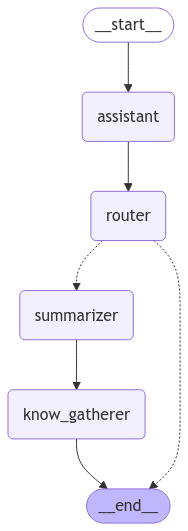

In [12]:
graph_builder.compile()

In [13]:
graph=graph_builder.compile(checkpointer=memory)

In [14]:
response = graph.invoke({
    'messages': [HumanMessage(content="Hello there")],'summary':[],'got_all':False,
},config=config)

In [15]:
response

{'messages': [HumanMessage(content='Hello there', additional_kwargs={}, response_metadata={}, id='25fc9657-fe54-487f-841c-cc332312e805'),
  AIMessage(content="Hello! I'm your AI therapist, here to support you with your academic and emotional well-being. I understand that being a student can be challenging, and I'm here to listen and offer guidance.\n\nTo start, could you please tell me your name?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-278fef86-5f45-4efc-a96c-3d2f879e6b6b-0', usage_metadata={'input_tokens': 132, 'output_tokens': 56, 'total_tokens': 188, 'input_token_details': {'cache_read': 0}})],
 'got_all': False,
 'summary': ['**Student Name:** Not provided yet.\n**Reg Number/ID:** Not provided yet.\n**Mental Health:**  No information yet.\n**Main Concerns in Academics:** Not discussed.\n**Severity Status:**  Not applicable.\n**Stress Level:** Not applicable.'],
 

In [16]:
len(response['messages'])

2

In [17]:
response = graph.invoke({
    'messages': [HumanMessage(content="My name is Gokul, I need to get more gpa or Sagar will defeat me")],
},config=config)

In [18]:
response

{'messages': [HumanMessage(content='Hello there', additional_kwargs={}, response_metadata={}, id='25fc9657-fe54-487f-841c-cc332312e805'),
  AIMessage(content="Hello! I'm your AI therapist, here to support you with your academic and emotional well-being. I understand that being a student can be challenging, and I'm here to listen and offer guidance.\n\nTo start, could you please tell me your name?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-278fef86-5f45-4efc-a96c-3d2f879e6b6b-0', usage_metadata={'input_tokens': 132, 'output_tokens': 56, 'total_tokens': 188, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='My name is Gokul, I need to get more gpa or Sagar will defeat me', additional_kwargs={}, response_metadata={}, id='53cdf945-871d-4f15-a607-233be141ddea'),
  AIMessage(content="Hello Gokul, it's nice to meet you. It sounds like you're feeling quite a b

In [19]:
response = graph.invoke({
    'messages': [HumanMessage(content="I feel overwhelmed and about to take my own life because i hate to lose")],
},config=config)

In [20]:
response

{'messages': [HumanMessage(content='Hello there', additional_kwargs={}, response_metadata={}, id='25fc9657-fe54-487f-841c-cc332312e805'),
  AIMessage(content="Hello! I'm your AI therapist, here to support you with your academic and emotional well-being. I understand that being a student can be challenging, and I'm here to listen and offer guidance.\n\nTo start, could you please tell me your name?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-278fef86-5f45-4efc-a96c-3d2f879e6b6b-0', usage_metadata={'input_tokens': 132, 'output_tokens': 56, 'total_tokens': 188, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='My name is Gokul, I need to get more gpa or Sagar will defeat me', additional_kwargs={}, response_metadata={}, id='53cdf945-871d-4f15-a607-233be141ddea'),
  AIMessage(content="Hello Gokul, it's nice to meet you. It sounds like you're feeling quite a b

In [21]:
print(response['summary'][-1])

**Student Name:** Gokul
**Reg Number/ID:** Not provided
**Mental Health:** Initially expressed significant distress and suicidal ideation due to academic pressure and fear of losing to Sagar.  Further assessment is needed.
**Main Concerns in Academics:** Low GPA;  intense competition with Sagar (nature of competition unspecified).  Specific academic weaknesses or challenges are unknown.
**Severity Status:** SEVERE (due to expressed suicidal ideation)
**Stress Level:**  Not explicitly stated, but implied to be extremely high given the suicidal thoughts.


In [22]:
#run after kernel restart

response = graph.invoke({
    'messages': [HumanMessage(content="How do i defeat sagar, also tell my name so that i can check your memory")],
},config=config)


In [23]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hello there
================================== Ai Message ==================================

Hello! I'm your AI therapist, here to support you with your academic and emotional well-being. I understand that being a student can be challenging, and I'm here to listen and offer guidance.

To start, could you please tell me your name?
================================ Human Message =================================

My name is Gokul, I need to get more gpa or Sagar will defeat me
================================== Ai Message ==================================

Hello Gokul, it's nice to meet you. It sounds like you're feeling quite a bit of pressure regarding your GPA and this competition with Sagar. That kind of pressure can be really tough to deal with.

To help me understand the situation better, could you tell me a bit more about:

1.  **What are your main concerns in academics right now?**
2.  **How severe